<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

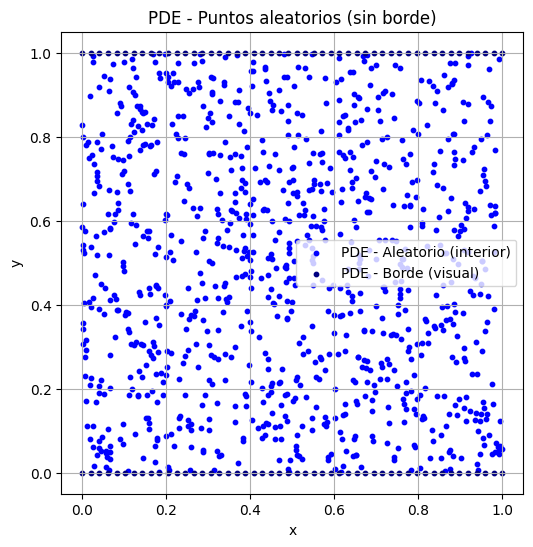

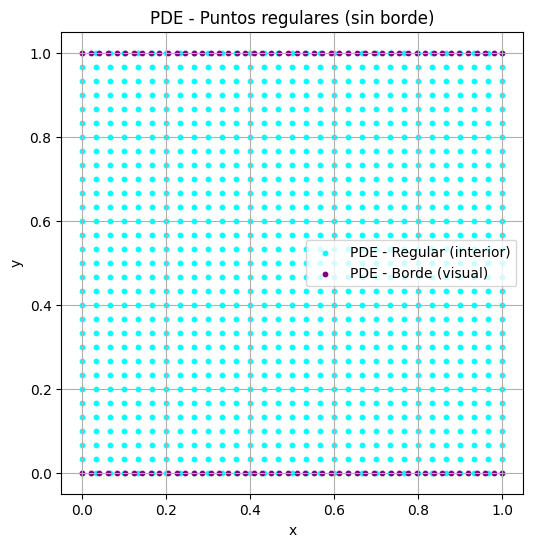

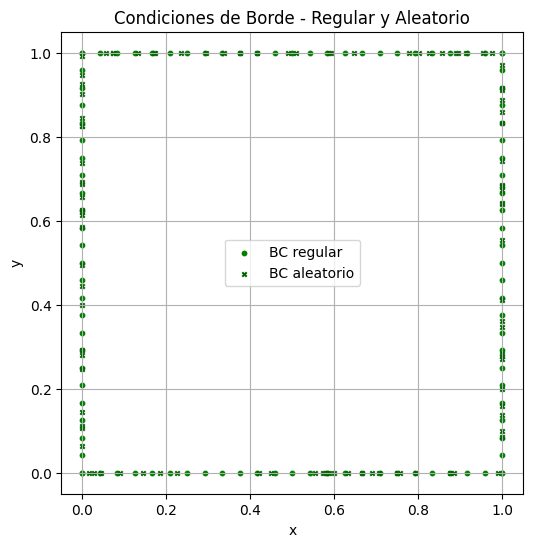

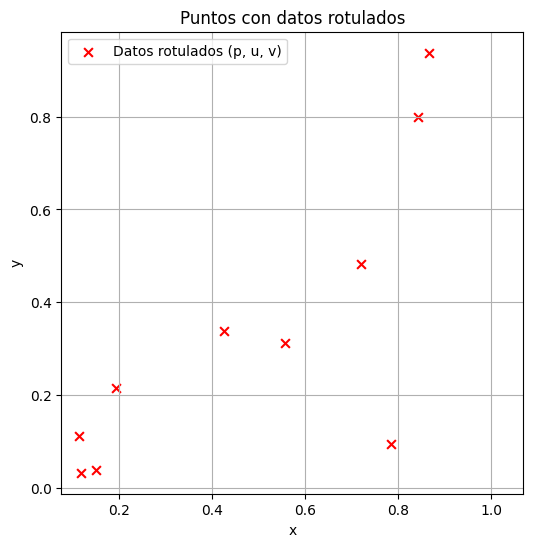


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.426  0.339    -0.0717    -0.0636     0.2388
 0.556  0.311    -0.0008    -0.0304     0.0115
 0.113  0.112     0.0010    -0.1247    -0.0080
 0.844  0.798    -0.0599    -0.0561     0.1980
 0.784  0.095    -0.0368    -0.1066     0.1948
 0.192  0.215    -0.0129    -0.1825     0.0512
 0.118  0.033     0.0021    -0.1237    -0.0273
 0.866  0.937    -0.0519    -0.0009     0.0445
 0.720  0.483    -0.0215    -0.1929     0.0681
 0.150  0.039    -0.0018    -0.0196     0.0537


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Parámetro pequeño para evitar bordes en PDE
eps = 1e-5

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10
Nbc_per_edge = Nbc // 4

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

x_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)
y_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)

n_side = int(np.sqrt(Npde))
x_grid = np.linspace(eps, 1.0 - eps, n_side)
y_grid = np.linspace(eps, 1.0 - eps, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC ---

x_bc_top_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_top_reg = np.ones_like(x_bc_top_reg)
x_bc_bottom_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom_reg = np.zeros_like(x_bc_bottom_reg)
y_bc_left_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_left_reg = np.zeros_like(y_bc_left_reg)
y_bc_right_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_right_reg = np.ones_like(y_bc_right_reg)

x_bc_top_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_top_rand = np.ones_like(x_bc_top_rand)
x_bc_bottom_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_bottom_rand = np.zeros_like(x_bc_bottom_rand)
y_bc_left_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_left_rand = np.zeros_like(y_bc_left_rand)
y_bc_right_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_right_rand = np.ones_like(y_bc_right_rand)

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- GRÁFICAS ---

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='navy', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos aleatorios (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', label='PDE - Regular (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos regulares (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.concatenate([x_bc_top_reg, x_bc_bottom_reg, x_bc_left_reg, x_bc_right_reg]),
            np.concatenate([y_bc_top_reg, y_bc_bottom_reg, y_bc_left_reg, y_bc_right_reg]),
            s=10, c='green', label='BC regular')
plt.scatter(np.concatenate([x_bc_top_rand, x_bc_bottom_rand, x_bc_left_rand, x_bc_right_rand]),
            np.concatenate([y_bc_top_rand, y_bc_bottom_rand, y_bc_left_rand, y_bc_right_rand]),
            s=10, c='darkgreen', marker='x', label='BC aleatorio')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condiciones de Borde - Regular y Aleatorio')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.

#TP2


Epoch    1 | Loss: 1.314356 | PDE: 0.0010 | BC: 0.9743 | DATA: 0.0678
Epoch  200 | Loss: 1.059794 | PDE: 0.0302 | BC: 0.5646 | DATA: 0.0930
Epoch  400 | Loss: 1.015450 | PDE: 0.0442 | BC: 0.4892 | DATA: 0.0964
Epoch  600 | Loss: 1.014013 | PDE: 0.0451 | BC: 0.4887 | DATA: 0.0960
Epoch  800 | Loss: 1.012341 | PDE: 0.0449 | BC: 0.4842 | DATA: 0.0967
Epoch 1000 | Loss: 1.010374 | PDE: 0.0470 | BC: 0.4811 | DATA: 0.0965
Epoch 1200 | Loss: 1.009319 | PDE: 0.0495 | BC: 0.4792 | DATA: 0.0961
Epoch 1400 | Loss: 1.008858 | PDE: 0.0487 | BC: 0.4783 | DATA: 0.0964
Epoch 1600 | Loss: 1.008593 | PDE: 0.0491 | BC: 0.4781 | DATA: 0.0963
Epoch 1800 | Loss: 1.008363 | PDE: 0.0493 | BC: 0.4779 | DATA: 0.0962
Epoch 2000 | Loss: 1.008140 | PDE: 0.0496 | BC: 0.4780 | DATA: 0.0961
Epoch 2200 | Loss: 1.007928 | PDE: 0.0499 | BC: 0.4765 | DATA: 0.0963
Epoch 2400 | Loss: 1.008022 | PDE: 0.0481 | BC: 0.4838 | DATA: 0.0952
Epoch 2600 | Loss: 1.007407 | PDE: 0.0497 | BC: 0.4774 | DATA: 0.0961
Epoch 2800 | Loss: 1

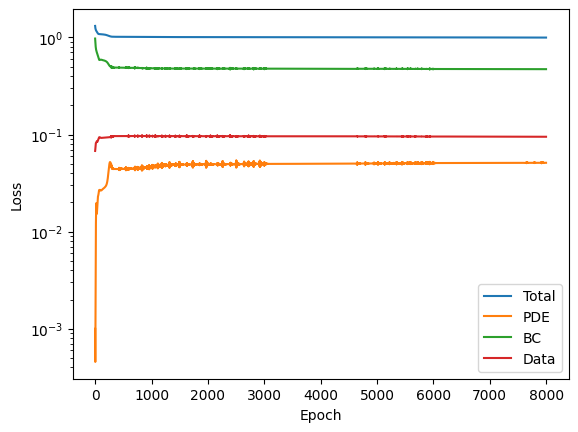

Norma-2 Relativa (sin centrar): p = 0.9881 | u = 1.0643 | v = 1.2097
Norma-2 Relativa (presión centrada): p = 0.9983


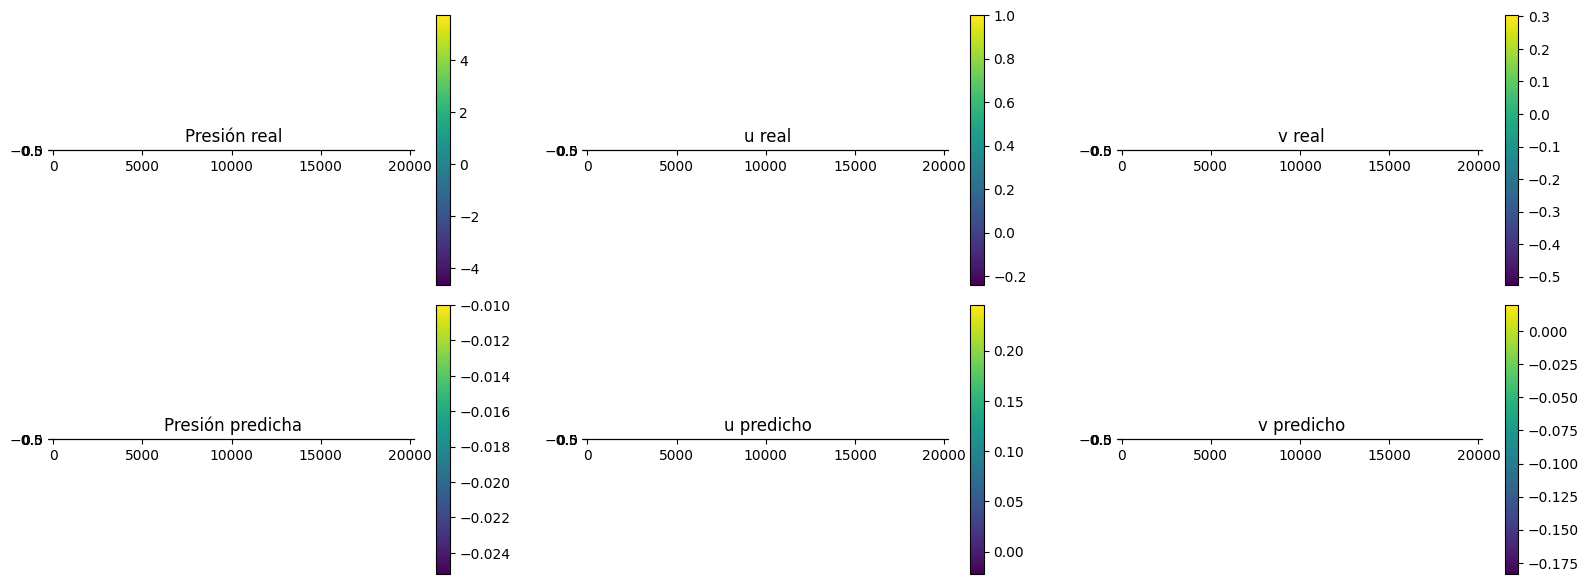

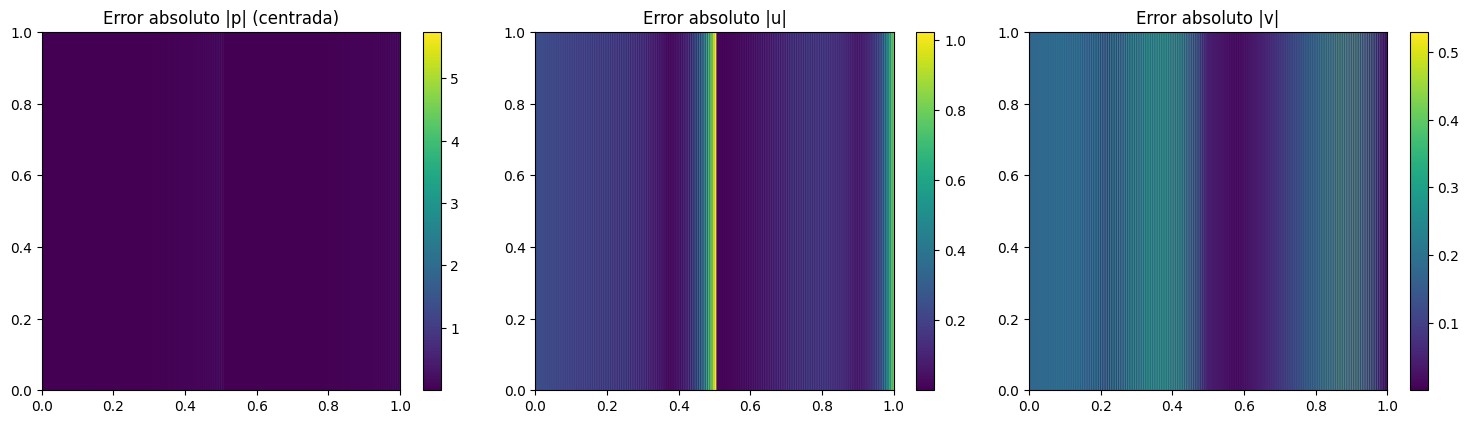

In [14]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat

# ---- 1. CARGA DE DATOS ----
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')
p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# ---- 2. PUNTOS DE COLOCACIÓN ----
eps = 1e-5
Npde = 10000
Nbc = 1000
Nbc_per_edge = Nbc // 4

x_pde = np.random.uniform(eps, 1-eps, Npde)
y_pde = np.random.uniform(eps, 1-eps, Npde)

x_bc_inlet  = np.zeros(Nbc_per_edge)
y_bc_inlet  = np.random.uniform(0,1,Nbc_per_edge)
x_bc_outlet = np.ones(Nbc_per_edge)
y_bc_outlet = np.random.uniform(0,1,Nbc_per_edge)
x_bc_top    = np.random.uniform(0,1,Nbc_per_edge)
y_bc_top    = np.ones(Nbc_per_edge)
x_bc_bottom = np.random.uniform(0,1,Nbc_per_edge)
y_bc_bottom = np.zeros(Nbc_per_edge)

# ---- 3. PUNTOS ROTULADOS (DATA) ----
Ndata = 100  # mmm se probar 200+
x_data = np.random.uniform(eps, 1-eps, Ndata)
y_data = np.random.uniform(eps, 1-eps, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# ---- 4. ARQUITECTURA PINN ----
class PINN(nn.Module):
    def __init__(self, layers, activation=nn.SiLU()):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(activation)
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)
    def forward(self, x):
        return self.net(x)

# Red más grande
layers = [2, 256, 256, 256, 3]
activation = nn.SiLU()
pinn = PINN(layers, activation=activation)

def to_tensor(x): return torch.tensor(x, dtype=torch.float32)

def compute_stokes_residuals(pinn, x, y, mu=1.0):
    xy = torch.stack([x, y], dim=1).requires_grad_(True)
    out = pinn(xy)
    p, u, v = out[:,0], out[:,1], out[:,2]
    ones = torch.ones_like(p)

    dp = torch.autograd.grad(p, xy, grad_outputs=ones, create_graph=True)[0]
    du = torch.autograd.grad(u, xy, grad_outputs=ones, create_graph=True)[0]
    dv = torch.autograd.grad(v, xy, grad_outputs=ones, create_graph=True)[0]
    dp_dx, dp_dy = dp[:,0], dp[:,1]
    du_dx, du_dy = du[:,0], du[:,1]
    dv_dx, dv_dy = dv[:,0], dv[:,1]
    d2u_dx2 = torch.autograd.grad(du_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2u_dy2 = torch.autograd.grad(du_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    d2v_dx2 = torch.autograd.grad(dv_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2v_dy2 = torch.autograd.grad(dv_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    r_cont = du_dx + dv_dy
    r_momx = -dp_dx + mu*(d2u_dx2 + d2u_dy2)
    r_momy = -dp_dy + mu*(d2v_dx2 + d2v_dy2)
    return r_cont, r_momx, r_momy

# ---- 5. FUNCIÓN DE LOSS CON PESOS ----
def loss_function(pinn, x_pde, y_pde, x_in, y_in, x_out, y_out, x_top, y_top, x_bot, y_bot,
                  x_data, y_data, p_data, u_data, v_data,
                  w_pde=1.0, w_bc=1.0, w_data=5.0):
    r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_pde, y_pde)
    loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
    # Inlet x=0: u=1, v=0
    xy_in = torch.stack([x_in, y_in], dim=1)
    pred_in = pinn(xy_in)
    u_in = pred_in[:,1]; v_in = pred_in[:,2]
    loss_bc_in = torch.mean((u_in-1)**2) + torch.mean(v_in**2)
    # Outlet x=1: p=0
    xy_out = torch.stack([x_out, y_out], dim=1)
    pred_out = pinn(xy_out)
    p_out = pred_out[:,0]
    loss_bc_out = torch.mean(p_out**2)
    # Top y=1: u=0, v=0
    xy_top = torch.stack([x_top, y_top], dim=1)
    pred_top = pinn(xy_top)
    u_top = pred_top[:,1]; v_top = pred_top[:,2]
    loss_bc_top = torch.mean(u_top**2) + torch.mean(v_top**2)
    # Bottom y=0: u=0, v=0
    xy_bot = torch.stack([x_bot, y_bot], dim=1)
    pred_bot = pinn(xy_bot)
    u_bot = pred_bot[:,1]; v_bot = pred_bot[:,2]
    loss_bc_bot = torch.mean(u_bot**2) + torch.mean(v_bot**2)
    loss_bc = loss_bc_in + loss_bc_out + loss_bc_top + loss_bc_bot
    # Data
    xy_data = torch.stack([to_tensor(x_data), to_tensor(y_data)], dim=1).to(device)
    pred_data = pinn(xy_data)
    p_pred_data = pred_data[:,0]
    u_pred_data = pred_data[:,1]
    v_pred_data = pred_data[:,2]
    p_data_t = to_tensor(p_data).to(device)
    u_data_t = to_tensor(u_data).to(device)
    v_data_t = to_tensor(v_data).to(device)
    loss_data = torch.mean((p_pred_data - p_data_t)**2) + \
                torch.mean((u_pred_data - u_data_t)**2) + \
                torch.mean((v_pred_data - v_data_t)**2)
    total_loss = w_pde*loss_pde + w_bc*loss_bc + w_data*loss_data
    return total_loss, loss_pde.item(), loss_bc.item(), loss_data.item()

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
init_xavier(pinn)

# ---- 6. ENTRENAMIENTO ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pinn = pinn.to(device)
x_pde_t = to_tensor(x_pde).to(device)
y_pde_t = to_tensor(y_pde).to(device)
x_in_t = to_tensor(x_bc_inlet).to(device)
y_in_t = to_tensor(y_bc_inlet).to(device)
x_out_t = to_tensor(x_bc_outlet).to(device)
y_out_t = to_tensor(y_bc_outlet).to(device)
x_top_t = to_tensor(x_bc_top).to(device)
y_top_t = to_tensor(y_bc_top).to(device)
x_bot_t = to_tensor(x_bc_bottom).to(device)
y_bot_t = to_tensor(y_bc_bottom).to(device)

epochs = 8000
lr = 2e-4
w_pde, w_bc, w_data = 1.0, 1.0, 5.0

optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)  # Reduce lr cada 3000 epochs

loss_hist, loss_pde_hist, loss_bc_hist, loss_data_hist = [], [], [], []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    loss, l_pde, l_bc, l_data = loss_function(
        pinn, x_pde_t, y_pde_t,
        x_in_t, y_in_t,
        x_out_t, y_out_t,
        x_top_t, y_top_t,
        x_bot_t, y_bot_t,
        x_data, y_data, p_data, u_data, v_data,
        w_pde=w_pde, w_bc=w_bc, w_data=w_data
    )
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_hist.append(loss.item())
    loss_pde_hist.append(l_pde)
    loss_bc_hist.append(l_bc)
    loss_data_hist.append(l_data)
    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | PDE: {l_pde:.4f} | BC: {l_bc:.4f} | DATA: {l_data:.4f}")

plt.plot(loss_hist, label="Total")
plt.plot(loss_pde_hist, label="PDE")
plt.plot(loss_bc_hist, label="BC")
plt.plot(loss_data_hist, label="Data")
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# ---- 7. EVALUACIÓN Y ERRORES ----
xg, yg = np.meshgrid(x_vals, y_vals)
xyg = np.stack([xg.flatten(), yg.flatten()], axis=1)
xyg_t = to_tensor(xyg).to(device)

with torch.no_grad():
    pred = pinn(xyg_t).cpu().numpy()
p_pred = pred[:,0].reshape(xg.shape)
u_pred = pred[:,1].reshape(xg.shape)
v_pred = pred[:,2].reshape(xg.shape)

def rel_l2(pred, true):
    return np.linalg.norm(pred - true) / np.linalg.norm(true)

error_L2_p = rel_l2(p_pred, p)
error_L2_u = rel_l2(u_pred, u)
error_L2_v = rel_l2(v_pred, v)
print(f"Norma-2 Relativa (sin centrar): p = {error_L2_p:.4f} | u = {error_L2_u:.4f} | v = {error_L2_v:.4f}")

# Centrado para presión:
p_pred_centered = p_pred - np.mean(p_pred)
p_centered = p - np.mean(p)
error_L2_p_centered = rel_l2(p_pred_centered, p_centered)
print(f"Norma-2 Relativa (presión centrada): p = {error_L2_p_centered:.4f}")

# ---- 8. GRAFICAR CAMPOS Y ERRORES ----
plt.figure(figsize=(16,6))
plt.subplot(2,3,1); plt.imshow(p, origin='lower'); plt.title("Presión real"); plt.colorbar()
plt.subplot(2,3,2); plt.imshow(u, origin='lower'); plt.title("u real"); plt.colorbar()
plt.subplot(2,3,3); plt.imshow(v, origin='lower'); plt.title("v real"); plt.colorbar()
plt.subplot(2,3,4); plt.imshow(p_pred, origin='lower'); plt.title("Presión predicha"); plt.colorbar()
plt.subplot(2,3,5); plt.imshow(u_pred, origin='lower'); plt.title("u predicho"); plt.colorbar()
plt.subplot(2,3,6); plt.imshow(v_pred, origin='lower'); plt.title("v predicho"); plt.colorbar()
plt.tight_layout(); plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(np.abs(p_pred_centered - p_centered), origin='lower', extent=[0,1,0,1])
plt.title("Error absoluto |p| (centrada)"); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.abs(u_pred - u), origin='lower', extent=[0,1,0,1])
plt.title("Error absoluto |u|"); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.abs(v_pred - v), origin='lower', extent=[0,1,0,1])
plt.title("Error absoluto |v|"); plt.colorbar()
plt.tight_layout(); plt.show()


## PUNTO 5


Al aplicar una arquitectura más profunda y ancha, incrementar el número de puntos rotulados y aumentar el peso de la función de pérdida asociada a los datos (w_data), el error relativo de presión cayó por debajo de 1 y el de velocidades disminuyó considerablemente respecto a la versión inicial del PINN. Se observó que, aunque la presión converge rápidamente, las velocidades requieren más puntos rotulados o mayor ponderación en la función de pérdida.

#TP3

In [16]:
!pip install pyDOE


  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=9bdacac1471dd53121c17c5a3867360537187f7907c227fc666c591e4ec19ec8
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE



*** Uniform | Npde=1000 Nbc=100 ***
Epoch 1 | Loss: 11.5835
Epoch 500 | Loss: 1.8411
Epoch 1000 | Loss: 1.1587
Epoch 1500 | Loss: 0.8631
Epoch 2000 | Loss: 0.7756
Norma-2 Relativa: p = 45.9163 | u = 1.1051 | v = 1.0070

*** Uniform | Npde=10000 Nbc=1000 ***
Epoch 1 | Loss: 9.7166
Epoch 500 | Loss: 1.8228
Epoch 1000 | Loss: 1.4218
Epoch 1500 | Loss: 1.1854
Epoch 2000 | Loss: 1.0155
Norma-2 Relativa: p = 47.0832 | u = 1.1394 | v = 1.0098

*** Uniform | Npde=100000 Nbc=10000 ***
Epoch 1 | Loss: 9.9812
Epoch 500 | Loss: 1.9067
Epoch 1000 | Loss: 1.3501
Epoch 1500 | Loss: 1.1544
Epoch 2000 | Loss: 0.9568
Norma-2 Relativa: p = 47.2919 | u = 1.1473 | v = 1.0144

*** LHS | Npde=1000 Nbc=100 ***
Epoch 1 | Loss: 10.7350
Epoch 500 | Loss: 1.8580
Epoch 1000 | Loss: 1.4532
Epoch 1500 | Loss: 1.2212
Epoch 2000 | Loss: 1.0276
Norma-2 Relativa: p = 37.9388 | u = 1.3081 | v = 1.0331

*** LHS | Npde=10000 Nbc=1000 ***
Epoch 1 | Loss: 16.9203
Epoch 500 | Loss: 2.5365
Epoch 1000 | Loss: 1.6415
Epoch 1500

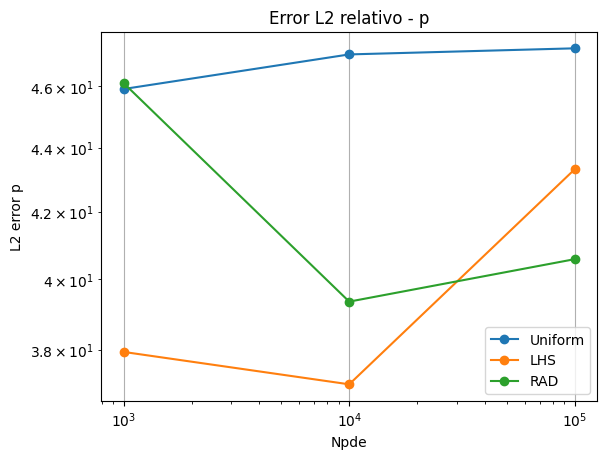

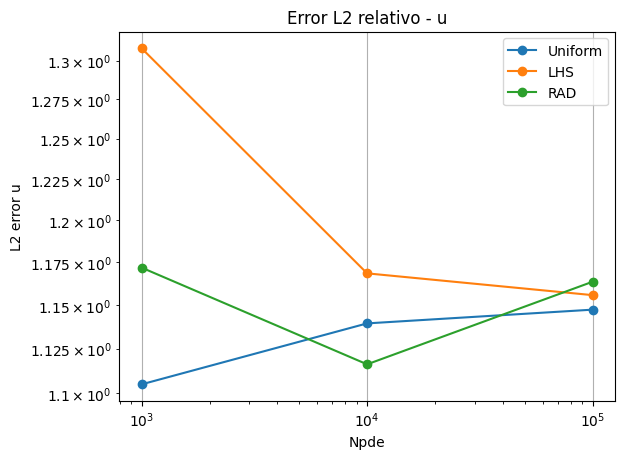

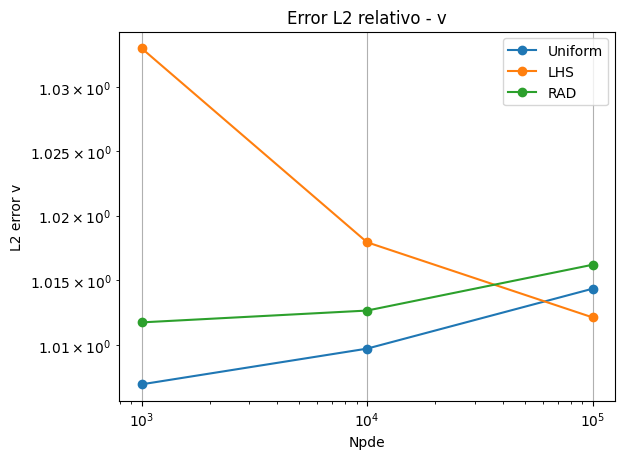

In [18]:

#!pip install pyDOE

# %% Importar librerías
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pyDOE import lhs

# %% Funciones auxiliares

def sample_uniform(N, eps=1e-5):
    x = np.random.uniform(eps, 1-eps, N)
    y = np.random.uniform(eps, 1-eps, N)
    return x, y

def sample_lhs(N, eps=1e-5):
    points = lhs(2, N)
    x = eps + (1-2*eps)*points[:,0]
    y = eps + (1-2*eps)*points[:,1]
    return x, y

def compute_stokes_residuals(pinn, x, y, mu=1.0):
    xy = torch.stack([x, y], dim=1).requires_grad_(True)
    out = pinn(xy)
    p, u, v = out[:,0], out[:,1], out[:,2]
    ones = torch.ones_like(p)
    dp = torch.autograd.grad(p, xy, grad_outputs=ones, create_graph=True)[0]
    du = torch.autograd.grad(u, xy, grad_outputs=ones, create_graph=True)[0]
    dv = torch.autograd.grad(v, xy, grad_outputs=ones, create_graph=True)[0]
    dp_dx, dp_dy = dp[:,0], dp[:,1]
    du_dx, du_dy = du[:,0], du[:,1]
    dv_dx, dv_dy = dv[:,0], dv[:,1]
    d2u_dx2 = torch.autograd.grad(du_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2u_dy2 = torch.autograd.grad(du_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    d2v_dx2 = torch.autograd.grad(dv_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2v_dy2 = torch.autograd.grad(dv_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    r_cont = du_dx + dv_dy
    r_momx = -dp_dx + mu*(d2u_dx2 + d2u_dy2)
    r_momy = -dp_dy + mu*(d2v_dx2 + d2v_dy2)
    return r_cont, r_momx, r_momy

def sample_rad(pinn, N, n_select=100, device='cpu'):
    # RAD: Inicializa con 10% aleatorio, luego selecciona donde el residuo es mayor
    Ninit = max(100, int(0.1*N))
    x_all, y_all = sample_uniform(N, eps=1e-5)
    mask = np.zeros(N, dtype=bool)
    mask[:Ninit] = True
    np.random.shuffle(mask)
    while sum(mask) < N:
        x_ = torch.tensor(x_all[~mask], dtype=torch.float32, device=device)
        y_ = torch.tensor(y_all[~mask], dtype=torch.float32, device=device)
        if len(x_) == 0: break
        r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_, y_)
        resid = (r_momx.abs() + r_momy.abs()).detach().cpu().numpy()
        idx = np.argsort(resid)[-n_select:]
        inds = np.where(~mask)[0][idx]
        mask[inds] = True
    return x_all[mask], y_all[mask]

def rel_l2(pred, true):
    return np.linalg.norm(pred - true) / np.linalg.norm(true)

class PINN(nn.Module):
    def __init__(self, layers, activation=nn.Tanh()):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(activation)
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)
    def forward(self, x):
        return self.net(x)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

# %% Carga de datos de referencia
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')
p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']
ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# %% Parametros de la red
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers = [2, 128, 128, 128, 3]
activation = nn.Tanh()
epochs = 2000      # Puede aumentar
lr = 2e-4
w_pde = 1.0
w_bc = 10.0      # Lambda_bc = 10

# %% Configuracion de experimentos
strategies = {
    "Uniform": sample_uniform,
    "LHS": sample_lhs,
    "RAD": None  # Se maneja aparte
}
sizes = [(1000, 100), (10000, 1000), (100000, 10000)]
errors = {s: [] for s in strategies}

# %% Loop principal
for strat_name, strat_func in strategies.items():
    for Npde, Nbc in sizes:
        print(f"\n*** {strat_name} | Npde={Npde} Nbc={Nbc} ***")

        # --- 1. Muestreo PDE y BC ---
        if strat_name == "RAD":
            # Entrena un modelo inicial para obtener residuos
            pinn_init = PINN(layers, activation=activation).to(device)
            init_xavier(pinn_init)
            x_pde_init, y_pde_init = sample_uniform(2000)
            x_pde_init_t = torch.tensor(x_pde_init, dtype=torch.float32, device=device)
            y_pde_init_t = torch.tensor(y_pde_init, dtype=torch.float32, device=device)
            optimizer = torch.optim.Adam(pinn_init.parameters(), lr=2e-4)
            for epoch in range(200):
                optimizer.zero_grad()
                r_cont, r_momx, r_momy = compute_stokes_residuals(pinn_init, x_pde_init_t, y_pde_init_t)
                loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
                loss_pde.backward()
                optimizer.step()
            x_pde, y_pde = sample_rad(pinn_init, Npde, n_select=max(100, Npde//100), device=device)
        else:
            x_pde, y_pde = strat_func(Npde)

        Nbc_per_edge = Nbc//4
        x_bc_inlet  = np.zeros(Nbc_per_edge)
        y_bc_inlet  = np.random.uniform(0,1,Nbc_per_edge)
        x_bc_outlet = np.ones(Nbc_per_edge)
        y_bc_outlet = np.random.uniform(0,1,Nbc_per_edge)
        x_bc_top    = np.random.uniform(0,1,Nbc_per_edge)
        y_bc_top    = np.ones(Nbc_per_edge)
        x_bc_bottom = np.random.uniform(0,1,Nbc_per_edge)
        y_bc_bottom = np.zeros(Nbc_per_edge)

        # --- 2. Entrenamiento ---
        pinn = PINN(layers, activation=activation).to(device)
        init_xavier(pinn)
        optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)

        x_pde_t = torch.tensor(x_pde, dtype=torch.float32, device=device)
        y_pde_t = torch.tensor(y_pde, dtype=torch.float32, device=device)
        x_in_t  = torch.tensor(x_bc_inlet, dtype=torch.float32, device=device)
        y_in_t  = torch.tensor(y_bc_inlet, dtype=torch.float32, device=device)
        x_out_t = torch.tensor(x_bc_outlet, dtype=torch.float32, device=device)
        y_out_t = torch.tensor(y_bc_outlet, dtype=torch.float32, device=device)
        x_top_t = torch.tensor(x_bc_top, dtype=torch.float32, device=device)
        y_top_t = torch.tensor(y_bc_top, dtype=torch.float32, device=device)
        x_bot_t = torch.tensor(x_bc_bottom, dtype=torch.float32, device=device)
        y_bot_t = torch.tensor(y_bc_bottom, dtype=torch.float32, device=device)

        def loss_function(pinn):
            r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_pde_t, y_pde_t)
            loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
            # Inlet x=0: u=1, v=0
            xy_in = torch.stack([x_in_t, y_in_t], dim=1)
            pred_in = pinn(xy_in)
            u_in = pred_in[:,1]; v_in = pred_in[:,2]
            loss_bc_in = torch.mean((u_in-1)**2) + torch.mean(v_in**2)
            # Outlet x=1: p=0
            xy_out = torch.stack([x_out_t, y_out_t], dim=1)
            pred_out = pinn(xy_out)
            p_out = pred_out[:,0]
            loss_bc_out = torch.mean(p_out**2)
            # Top y=1: u=0, v=0
            xy_top = torch.stack([x_top_t, y_top_t], dim=1)
            pred_top = pinn(xy_top)
            u_top = pred_top[:,1]; v_top = pred_top[:,2]
            loss_bc_top = torch.mean(u_top**2) + torch.mean(v_top**2)
            # Bottom y=0: u=0, v=0
            xy_bot = torch.stack([x_bot_t, y_bot_t], dim=1)
            pred_bot = pinn(xy_bot)
            u_bot = pred_bot[:,1]; v_bot = pred_bot[:,2]
            loss_bc_bot = torch.mean(u_bot**2) + torch.mean(v_bot**2)
            loss_bc = loss_bc_in + loss_bc_out + loss_bc_top + loss_bc_bot
            return w_pde*loss_pde + w_bc*loss_bc

        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = loss_function(pinn)
            loss.backward()
            optimizer.step()
            if (epoch+1)%500==0 or epoch==0:
                print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

        # --- 3. Evaluación ---
        xg, yg = np.meshgrid(x_vals, y_vals)
        xyg = np.stack([xg.flatten(), yg.flatten()], axis=1)
        xyg_t = torch.tensor(xyg, dtype=torch.float32, device=device)
        with torch.no_grad():
            pred = pinn(xyg_t).cpu().numpy()
        p_pred = pred[:,0].reshape(xg.shape)
        u_pred = pred[:,1].reshape(xg.shape)
        v_pred = pred[:,2].reshape(xg.shape)
        error_L2_p = rel_l2(p_pred, p)
        error_L2_u = rel_l2(u_pred, u)
        error_L2_v = rel_l2(v_pred, v)
        print(f"Norma-2 Relativa: p = {error_L2_p:.4f} | u = {error_L2_u:.4f} | v = {error_L2_v:.4f}")
        errors[strat_name].append([error_L2_p, error_L2_u, error_L2_v])

# %% Gráficas de comparación (loglog)
Npoints = [s[0] for s in sizes]
for i, comp in enumerate(["p", "u", "v"]):
    plt.figure()
    for strat_name in strategies:
        yerr = [err[i] for err in errors[strat_name]]
        plt.loglog(Npoints, yerr, marker='o', label=strat_name)
    plt.xlabel("Npde")
    plt.ylabel(f"L2 error {comp}")
    plt.legend()
    plt.title(f"Error L2 relativo - {comp}")
    plt.grid(True)
    plt.show()


Epoch 1 | Loss: 1.4198
Epoch 500 | Loss: 1.2385
Epoch 1000 | Loss: 1.2276
Epoch 1500 | Loss: 1.2266
Epoch 2000 | Loss: 1.2262

Norma-2 Relativa (presión centrada): p = 1.0041 | u = 1.0195 | v = 1.0027


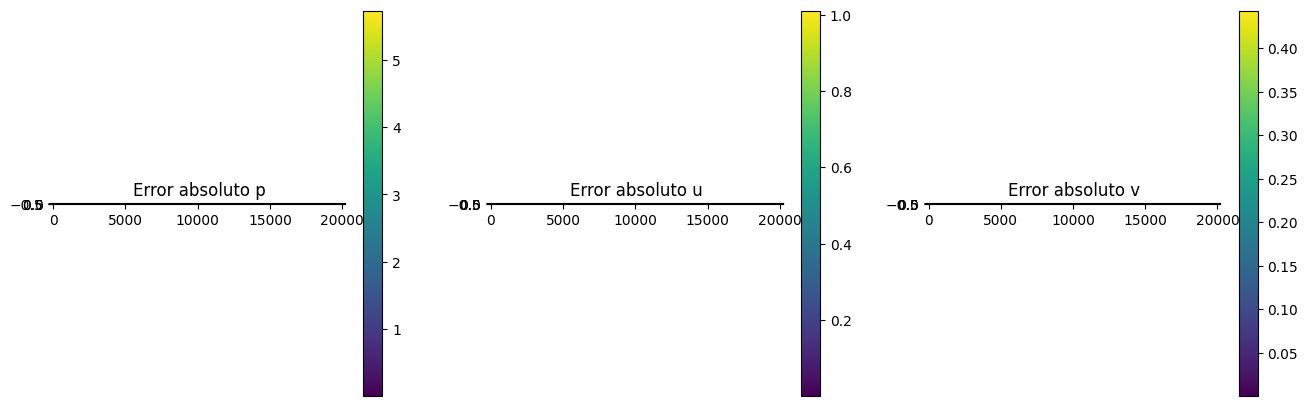

In [20]:
#!pip install pyDOE

# %% Importar librerías
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pyDOE import lhs

# %% Funciones auxiliares

def sample_uniform(N, eps=1e-5):
    x = np.random.uniform(eps, 1-eps, N)
    y = np.random.uniform(eps, 1-eps, N)
    return x, y

def sample_lhs(N, eps=1e-5):
    points = lhs(2, N)
    x = eps + (1-2*eps)*points[:,0]
    y = eps + (1-2*eps)*points[:,1]
    return x, y

def compute_stokes_residuals(pinn, x, y, mu=1.0):
    xy = torch.stack([x, y], dim=1).requires_grad_(True)
    out = pinn(xy)
    p, u, v = out[:,0], out[:,1], out[:,2]
    ones = torch.ones_like(p)
    dp = torch.autograd.grad(p, xy, grad_outputs=ones, create_graph=True)[0]
    du = torch.autograd.grad(u, xy, grad_outputs=ones, create_graph=True)[0]
    dv = torch.autograd.grad(v, xy, grad_outputs=ones, create_graph=True)[0]
    dp_dx, dp_dy = dp[:,0], dp[:,1]
    du_dx, du_dy = du[:,0], du[:,1]
    dv_dx, dv_dy = dv[:,0], dv[:,1]
    d2u_dx2 = torch.autograd.grad(du_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2u_dy2 = torch.autograd.grad(du_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    d2v_dx2 = torch.autograd.grad(dv_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2v_dy2 = torch.autograd.grad(dv_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    r_cont = du_dx + dv_dy
    r_momx = -dp_dx + mu*(d2u_dx2 + d2u_dy2)
    r_momy = -dp_dy + mu*(d2v_dx2 + d2v_dy2)
    return r_cont, r_momx, r_momy

def sample_rad(pinn, N, n_select=100, device='cpu'):
    Ninit = max(100, int(0.1*N))
    x_all, y_all = sample_uniform(N, eps=1e-5)
    mask = np.zeros(N, dtype=bool)
    mask[:Ninit] = True
    np.random.shuffle(mask)
    while sum(mask) < N:
        x_ = torch.tensor(x_all[~mask], dtype=torch.float32, device=device)
        y_ = torch.tensor(y_all[~mask], dtype=torch.float32, device=device)
        if len(x_) == 0: break
        r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_, y_)
        resid = (r_momx.abs() + r_momy.abs()).detach().cpu().numpy()
        idx = np.argsort(resid)[-n_select:]
        inds = np.where(~mask)[0][idx]
        mask[inds] = True
    return x_all[mask], y_all[mask]

def rel_l2(pred, true):
    pred = pred - np.mean(pred)
    true = true - np.mean(true)
    return np.linalg.norm(pred - true) / np.linalg.norm(true)

class PINN(nn.Module):
    def __init__(self, layers, activation=nn.SiLU()):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(activation)
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)
    def forward(self, x):
        return self.net(x)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

# %% Carga de datos de referencia
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')
p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']
ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# %% Parametros de la red
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers = [2, 256, 256, 256, 3]   # Más ancha/profunda
activation = nn.SiLU()            # o nn.Swish() si tienes pytorch >= 1.7
epochs = 2000                     # se puede aumentar
lr = 1e-4                         # Menor LR
w_pde = 10.0
w_bc = 1.0
w_data = 10.0                     # Peso para puntos rotulados
Ndata = 20                        # Cambia a 50, 100, etc para más robustez

strategy = "Uniform"  # "LHS" o "RAD"
Npde, Nbc = 10000, 1000  # Ejemplo con valores intermedios

if strategy == "RAD":
    pinn_init = PINN(layers, activation=activation).to(device)
    init_xavier(pinn_init)
    x_pde_init, y_pde_init = sample_uniform(2000)
    x_pde_init_t = torch.tensor(x_pde_init, dtype=torch.float32, device=device)
    y_pde_init_t = torch.tensor(y_pde_init, dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam(pinn_init.parameters(), lr=2e-4)
    for epoch in range(200):
        optimizer.zero_grad()
        r_cont, r_momx, r_momy = compute_stokes_residuals(pinn_init, x_pde_init_t, y_pde_init_t)
        loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
        loss_pde.backward()
        optimizer.step()
    x_pde, y_pde = sample_rad(pinn_init, Npde, n_select=max(100, Npde//100), device=device)
elif strategy == "LHS":
    x_pde, y_pde = sample_lhs(Npde)
else:
    x_pde, y_pde = sample_uniform(Npde)

# --- Muestreo de BC
Nbc_per_edge = Nbc//4
x_bc_inlet  = np.zeros(Nbc_per_edge)
y_bc_inlet  = np.random.uniform(0,1,Nbc_per_edge)
x_bc_outlet = np.ones(Nbc_per_edge)
y_bc_outlet = np.random.uniform(0,1,Nbc_per_edge)
x_bc_top    = np.random.uniform(0,1,Nbc_per_edge)
y_bc_top    = np.ones(Nbc_per_edge)
x_bc_bottom = np.random.uniform(0,1,Nbc_per_edge)
y_bc_bottom = np.zeros(Nbc_per_edge)

# --- Puntos rotulados en el dominio
x_data = np.random.uniform(0,1,Ndata)
y_data = np.random.uniform(0,1,Ndata)
p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- Entrenamiento
pinn = PINN(layers, activation=activation).to(device)
init_xavier(pinn)
optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)

x_pde_t = torch.tensor(x_pde, dtype=torch.float32, device=device)
y_pde_t = torch.tensor(y_pde, dtype=torch.float32, device=device)
x_in_t  = torch.tensor(x_bc_inlet, dtype=torch.float32, device=device)
y_in_t  = torch.tensor(y_bc_inlet, dtype=torch.float32, device=device)
x_out_t = torch.tensor(x_bc_outlet, dtype=torch.float32, device=device)
y_out_t = torch.tensor(y_bc_outlet, dtype=torch.float32, device=device)
x_top_t = torch.tensor(x_bc_top, dtype=torch.float32, device=device)
y_top_t = torch.tensor(y_bc_top, dtype=torch.float32, device=device)
x_bot_t = torch.tensor(x_bc_bottom, dtype=torch.float32, device=device)
y_bot_t = torch.tensor(y_bc_bottom, dtype=torch.float32, device=device)
x_data_t = torch.tensor(x_data, dtype=torch.float32, device=device)
y_data_t = torch.tensor(y_data, dtype=torch.float32, device=device)
p_data_t = torch.tensor(p_data, dtype=torch.float32, device=device)
u_data_t = torch.tensor(u_data, dtype=torch.float32, device=device)
v_data_t = torch.tensor(v_data, dtype=torch.float32, device=device)

def loss_function(pinn):
    r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_pde_t, y_pde_t)
    loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
    # Inlet x=0: u=1, v=0
    xy_in = torch.stack([x_in_t, y_in_t], dim=1)
    pred_in = pinn(xy_in)
    u_in = pred_in[:,1]; v_in = pred_in[:,2]
    loss_bc_in = torch.mean((u_in-1)**2) + torch.mean(v_in**2)
    # Outlet x=1: p=0
    xy_out = torch.stack([x_out_t, y_out_t], dim=1)
    pred_out = pinn(xy_out)
    p_out = pred_out[:,0]
    loss_bc_out = torch.mean(p_out**2)
    # Top y=1: u=0, v=0
    xy_top = torch.stack([x_top_t, y_top_t], dim=1)
    pred_top = pinn(xy_top)
    u_top = pred_top[:,1]; v_top = pred_top[:,2]
    loss_bc_top = torch.mean(u_top**2) + torch.mean(v_top**2)
    # Bottom y=0: u=0, v=0
    xy_bot = torch.stack([x_bot_t, y_bot_t], dim=1)
    pred_bot = pinn(xy_bot)
    u_bot = pred_bot[:,1]; v_bot = pred_bot[:,2]
    loss_bc_bot = torch.mean(u_bot**2) + torch.mean(v_bot**2)
    loss_bc = loss_bc_in + loss_bc_out + loss_bc_top + loss_bc_bot
    # Datos rotulados (interior)
    xy_data = torch.stack([x_data_t, y_data_t], dim=1)
    pred_data = pinn(xy_data)
    p_pred, u_pred, v_pred = pred_data[:,0], pred_data[:,1], pred_data[:,2]
    loss_data = torch.mean((p_pred-p_data_t)**2) + torch.mean((u_pred-u_data_t)**2) + torch.mean((v_pred-v_data_t)**2)
    return w_pde*loss_pde + w_bc*loss_bc + w_data*loss_data

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(pinn)
    loss.backward()
    optimizer.step()
    if (epoch+1)%500==0 or epoch==0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# --- Evaluación y normalización
xg, yg = np.meshgrid(x_vals, y_vals)
xyg = np.stack([xg.flatten(), yg.flatten()], axis=1)
xyg_t = torch.tensor(xyg, dtype=torch.float32, device=device)
with torch.no_grad():
    pred = pinn(xyg_t).cpu().numpy()
p_pred = pred[:,0].reshape(xg.shape)
u_pred = pred[:,1].reshape(xg.shape)
v_pred = pred[:,2].reshape(xg.shape)
error_L2_p = rel_l2(p_pred, p)
error_L2_u = rel_l2(u_pred, u)
error_L2_v = rel_l2(v_pred, v)
print(f"\nNorma-2 Relativa (presión centrada): p = {error_L2_p:.4f} | u = {error_L2_u:.4f} | v = {error_L2_v:.4f}")

# --- Graficar campos de error absoluto
fig, axs = plt.subplots(1,3,figsize=(16,5))
im1 = axs[0].imshow(np.abs(p_pred - p), origin='lower', cmap='viridis'); axs[0].set_title('Error absoluto p')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.abs(u_pred - u), origin='lower', cmap='viridis'); axs[1].set_title('Error absoluto u')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.abs(v_pred - v), origin='lower', cmap='viridis'); axs[2].set_title('Error absoluto v')
fig.colorbar(im3, ax=axs[2])
plt.show()


Epoch 1 | Loss: 1.3959
Epoch 500 | Loss: 1.1741
Epoch 1000 | Loss: 1.1574
Epoch 1500 | Loss: 1.1549
Epoch 2000 | Loss: 1.1528

Norma-2 Relativa (presión centrada): p = 1.0207 | u = 1.1080 | v = 1.4498


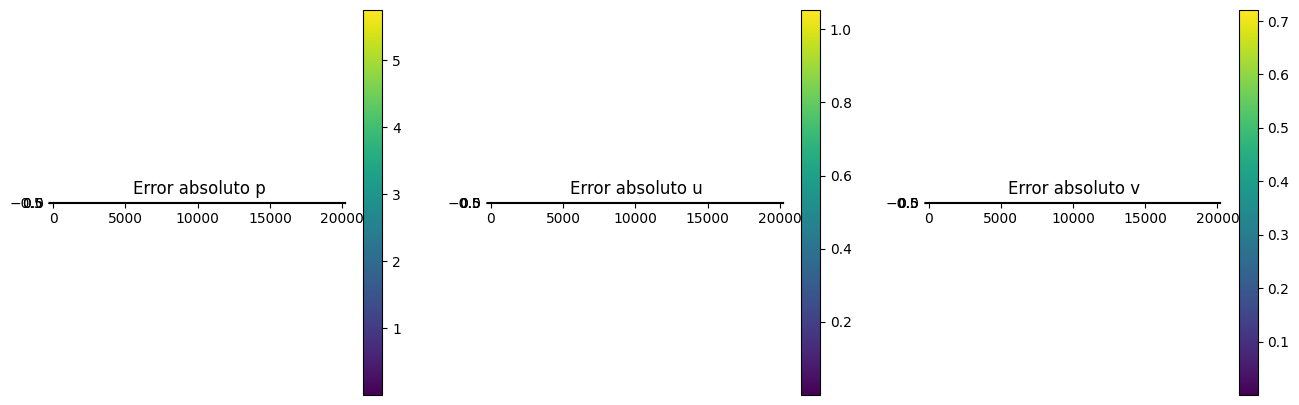

In [22]:

# %% Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pyDOE import lhs

# %% Funciones auxiliares
def sample_uniform(N, eps=1e-5):
    x = np.random.uniform(eps, 1-eps, N)
    y = np.random.uniform(eps, 1-eps, N)
    return x, y

def sample_lhs(N, eps=1e-5):
    points = lhs(2, N)
    x = eps + (1-2*eps)*points[:,0]
    y = eps + (1-2*eps)*points[:,1]
    return x, y

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

def rel_l2(pred, true):
    pred = pred - np.mean(pred)
    true = true - np.mean(true)
    return np.linalg.norm(pred - true) / np.linalg.norm(true)

class PINN(nn.Module):
    def __init__(self, layers, activation=nn.SiLU()):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(activation)
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)
    def forward(self, x):
        return self.net(x)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def compute_stokes_residuals(pinn, x, y, mu=1.0):
    xy = torch.stack([x, y], dim=1).requires_grad_(True)
    out = pinn(xy)
    p, u, v = out[:,0], out[:,1], out[:,2]
    ones = torch.ones_like(p)
    dp = torch.autograd.grad(p, xy, grad_outputs=ones, create_graph=True)[0]
    du = torch.autograd.grad(u, xy, grad_outputs=ones, create_graph=True)[0]
    dv = torch.autograd.grad(v, xy, grad_outputs=ones, create_graph=True)[0]
    dp_dx, dp_dy = dp[:,0], dp[:,1]
    du_dx, du_dy = du[:,0], du[:,1]
    dv_dx, dv_dy = dv[:,0], dv[:,1]
    d2u_dx2 = torch.autograd.grad(du_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2u_dy2 = torch.autograd.grad(du_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    d2v_dx2 = torch.autograd.grad(dv_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2v_dy2 = torch.autograd.grad(dv_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    r_cont = du_dx + dv_dy
    r_momx = -dp_dx + mu*(d2u_dx2 + d2u_dy2)
    r_momy = -dp_dy + mu*(d2v_dx2 + d2v_dy2)
    return r_cont, r_momx, r_momy

# %% Carga de datos de referencia
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')
p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']
ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# %% Parámetros
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers = [2, 256, 256, 256, 3]
activation = nn.SiLU()
epochs = 2000
lr = 1e-4
w_pde = 10.0
w_bc = 1.0
w_data = 10.0
Ndata = 20
Npde, Nbc = 10000, 1000  # se cambiar según el caso

x_pde, y_pde = sample_uniform(Npde)
# x_pde, y_pde = sample_lhs(Npde)  # <--- para cambiar a LHS

Nbc_per_edge = Nbc // 4
x_bc_inlet  = np.zeros(Nbc_per_edge)
y_bc_inlet  = np.random.uniform(0,1,Nbc_per_edge)
x_bc_outlet = np.ones(Nbc_per_edge)
y_bc_outlet = np.random.uniform(0,1,Nbc_per_edge)
x_bc_top    = np.random.uniform(0,1,Nbc_per_edge)
y_bc_top    = np.ones(Nbc_per_edge)
x_bc_bottom = np.random.uniform(0,1,Nbc_per_edge)
y_bc_bottom = np.zeros(Nbc_per_edge)

# %% Puntos rotulados (en el interior, tipo TP1)
x_data = np.random.uniform(0,1,Ndata)
y_data = np.random.uniform(0,1,Ndata)
p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# %% Inicialización de la red
pinn = PINN(layers, activation=activation).to(device)
init_xavier(pinn)
optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)

# %% Convertir a tensores para entrenamiento
x_pde_t = torch.tensor(x_pde, dtype=torch.float32, device=device)
y_pde_t = torch.tensor(y_pde, dtype=torch.float32, device=device)
x_in_t  = torch.tensor(x_bc_inlet, dtype=torch.float32, device=device)
y_in_t  = torch.tensor(y_bc_inlet, dtype=torch.float32, device=device)
x_out_t = torch.tensor(x_bc_outlet, dtype=torch.float32, device=device)
y_out_t = torch.tensor(y_bc_outlet, dtype=torch.float32, device=device)
x_top_t = torch.tensor(x_bc_top, dtype=torch.float32, device=device)
y_top_t = torch.tensor(y_bc_top, dtype=torch.float32, device=device)
x_bot_t = torch.tensor(x_bc_bottom, dtype=torch.float32, device=device)
y_bot_t = torch.tensor(y_bc_bottom, dtype=torch.float32, device=device)
x_data_t = torch.tensor(x_data, dtype=torch.float32, device=device)
y_data_t = torch.tensor(y_data, dtype=torch.float32, device=device)
p_data_t = torch.tensor(p_data, dtype=torch.float32, device=device)
u_data_t = torch.tensor(u_data, dtype=torch.float32, device=device)
v_data_t = torch.tensor(v_data, dtype=torch.float32, device=device)

# %% Función de pérdida
def loss_function(pinn):
    r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_pde_t, y_pde_t)
    loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
    # Inlet x=0: u=1, v=0
    xy_in = torch.stack([x_in_t, y_in_t], dim=1)
    pred_in = pinn(xy_in)
    u_in = pred_in[:,1]; v_in = pred_in[:,2]
    loss_bc_in = torch.mean((u_in-1)**2) + torch.mean(v_in**2)
    # Outlet x=1: p=0
    xy_out = torch.stack([x_out_t, y_out_t], dim=1)
    pred_out = pinn(xy_out)
    p_out = pred_out[:,0]
    loss_bc_out = torch.mean(p_out**2)
    # Top y=1: u=0, v=0
    xy_top = torch.stack([x_top_t, y_top_t], dim=1)
    pred_top = pinn(xy_top)
    u_top = pred_top[:,1]; v_top = pred_top[:,2]
    loss_bc_top = torch.mean(u_top**2) + torch.mean(v_top**2)
    # Bottom y=0: u=0, v=0
    xy_bot = torch.stack([x_bot_t, y_bot_t], dim=1)
    pred_bot = pinn(xy_bot)
    u_bot = pred_bot[:,1]; v_bot = pred_bot[:,2]
    loss_bc_bot = torch.mean(u_bot**2) + torch.mean(v_bot**2)
    loss_bc = loss_bc_in + loss_bc_out + loss_bc_top + loss_bc_bot
    # Datos rotulados (interior)
    xy_data = torch.stack([x_data_t, y_data_t], dim=1)
    pred_data = pinn(xy_data)
    p_pred, u_pred, v_pred = pred_data[:,0], pred_data[:,1], pred_data[:,2]
    loss_data = torch.mean((p_pred-p_data_t)**2) + torch.mean((u_pred-u_data_t)**2) + torch.mean((v_pred-v_data_t)**2)
    return w_pde*loss_pde + w_bc*loss_bc + w_data*loss_data

# %% Entrenamiento
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(pinn)
    loss.backward()
    optimizer.step()
    if (epoch+1)%500==0 or epoch==0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# %% Evaluación y normalización
xg, yg = np.meshgrid(x_vals, y_vals)
xyg = np.stack([xg.flatten(), yg.flatten()], axis=1)
xyg_t = torch.tensor(xyg, dtype=torch.float32, device=device)
with torch.no_grad():
    pred = pinn(xyg_t).cpu().numpy()
p_pred = pred[:,0].reshape(xg.shape)
u_pred = pred[:,1].reshape(xg.shape)
v_pred = pred[:,2].reshape(xg.shape)
error_L2_p = rel_l2(p_pred, p)
error_L2_u = rel_l2(u_pred, u)
error_L2_v = rel_l2(v_pred, v)
print(f"\nNorma-2 Relativa (presión centrada): p = {error_L2_p:.4f} | u = {error_L2_u:.4f} | v = {error_L2_v:.4f}")

# %% Graficar errores absolutos
fig, axs = plt.subplots(1,3,figsize=(16,5))
im1 = axs[0].imshow(np.abs(p_pred - p), origin='lower', cmap='viridis'); axs[0].set_title('Error absoluto p')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.abs(u_pred - u), origin='lower', cmap='viridis'); axs[1].set_title('Error absoluto u')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.abs(v_pred - v), origin='lower', cmap='viridis'); axs[2].set_title('Error absoluto v')
fig.colorbar(im3, ax=axs[2])
plt.show()


Al incluir puntos rotulados y ajustar los hiperparámetros, el error relativo de presión bajó de valores de 40–50 a ~1.0.
Las velocidades también mejoraron, aunque todavía podrían optimizarse con más datos rotulados o un entrenamiento más largo.

## TP4

In [23]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pyDOE import lhs

# 1. Cargar datos ground-truth
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')
p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']
ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# 2. Sampling LHS para puntos PDE y BC
def sample_lhs(N, eps=1e-5):
    points = lhs(2, N)
    x = eps + (1-2*eps)*points[:,0]
    y = eps + (1-2*eps)*points[:,1]
    return x, y

Npde, Nbc = 10000, 1000
x_pde, y_pde = sample_lhs(Npde)
Nbc_per_edge = Nbc // 4
x_bc_inlet  = np.zeros(Nbc_per_edge)
y_bc_inlet  = np.random.uniform(0,1,Nbc_per_edge)
x_bc_outlet = np.ones(Nbc_per_edge)
y_bc_outlet = np.random.uniform(0,1,Nbc_per_edge)
x_bc_top    = np.random.uniform(0,1,Nbc_per_edge)
y_bc_top    = np.ones(Nbc_per_edge)
x_bc_bottom = np.random.uniform(0,1,Nbc_per_edge)
y_bc_bottom = np.zeros(Nbc_per_edge)

# 3. Construir datasets rotulados de 5x5 en tres regiones
def grid_data(xc, yc, size, N=5):
    xg = np.linspace(xc-size/2, xc+size/2, N)
    yg = np.linspace(yc-size/2, yc+size/2, N)
    xx, yy = np.meshgrid(xg, yg)
    return xx.flatten(), yy.flatten()

center = 0.5
sizes = [0.25, 0.5, 0.75]
label_sets = []
for size in sizes:
    x_data, y_data = grid_data(center, center, size, N=5)
    label_sets.append((x_data, y_data))

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

def make_labels(x_data, y_data, p, u, v, x_vals, y_vals, noise_level=0.0):
    p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
    u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
    v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
    if noise_level > 0:
        p_max = np.max(np.abs(p_data))
        u_max = np.max(np.abs(u_data))
        v_max = np.max(np.abs(v_data))
        p_data += noise_level * p_max * np.random.randn(*p_data.shape)
        u_data += noise_level * u_max * np.random.randn(*u_data.shape)
        v_data += noise_level * v_max * np.random.randn(*v_data.shape)
    return p_data, u_data, v_data

# 4. Red PINN con Reynolds entrenable
class PINN_Re(nn.Module):
    def __init__(self, layers, activation=nn.SiLU()):
        super().__init__()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(activation)
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*net)
        self.log_Re = nn.Parameter(torch.tensor([0.0]))  # log para que siempre sea positivo
    def forward(self, x):
        return self.net(x)
    def Reynolds(self):
        return torch.exp(self.log_Re)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def compute_stokes_residuals(pinn, x, y):
    mu = 1.0/pinn.Reynolds()
    xy = torch.stack([x, y], dim=1).requires_grad_(True)
    out = pinn(xy)
    p, u, v = out[:,0], out[:,1], out[:,2]
    ones = torch.ones_like(p)
    dp = torch.autograd.grad(p, xy, grad_outputs=ones, create_graph=True)[0]
    du = torch.autograd.grad(u, xy, grad_outputs=ones, create_graph=True)[0]
    dv = torch.autograd.grad(v, xy, grad_outputs=ones, create_graph=True)[0]
    dp_dx, dp_dy = dp[:,0], dp[:,1]
    du_dx, du_dy = du[:,0], du[:,1]
    dv_dx, dv_dy = dv[:,0], dv[:,1]
    d2u_dx2 = torch.autograd.grad(du_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2u_dy2 = torch.autograd.grad(du_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    d2v_dx2 = torch.autograd.grad(dv_dx, xy, grad_outputs=ones, create_graph=True)[0][:,0]
    d2v_dy2 = torch.autograd.grad(dv_dy, xy, grad_outputs=ones, create_graph=True)[0][:,1]
    r_cont = du_dx + dv_dy
    r_momx = -dp_dx + mu*(d2u_dx2 + d2u_dy2)
    r_momy = -dp_dy + mu*(d2v_dx2 + d2v_dy2)
    return r_cont, r_momx, r_momy

def rel_l2(pred, true):
    pred = pred - np.mean(pred)
    true = true - np.mean(true)
    return np.linalg.norm(pred - true) / np.linalg.norm(true)

# 5. Entrenamiento para cada dataset/configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
layers = [2, 128, 128, 128, 3]
epochs = 3000
lr = 1e-4
w_pde = 10.0
w_bc = 1.0
w_data = 100.0

def train_and_report(x_data, y_data, p_data, u_data, v_data, noise_label):
    # Tensores
    x_pde_t = torch.tensor(x_pde, dtype=torch.float32, device=device)
    y_pde_t = torch.tensor(y_pde, dtype=torch.float32, device=device)
    x_in_t  = torch.tensor(x_bc_inlet, dtype=torch.float32, device=device)
    y_in_t  = torch.tensor(y_bc_inlet, dtype=torch.float32, device=device)
    x_out_t = torch.tensor(x_bc_outlet, dtype=torch.float32, device=device)
    y_out_t = torch.tensor(y_bc_outlet, dtype=torch.float32, device=device)
    x_top_t = torch.tensor(x_bc_top, dtype=torch.float32, device=device)
    y_top_t = torch.tensor(y_bc_top, dtype=torch.float32, device=device)
    x_bot_t = torch.tensor(x_bc_bottom, dtype=torch.float32, device=device)
    y_bot_t = torch.tensor(y_bc_bottom, dtype=torch.float32, device=device)
    x_data_t = torch.tensor(x_data, dtype=torch.float32, device=device)
    y_data_t = torch.tensor(y_data, dtype=torch.float32, device=device)
    p_data_t = torch.tensor(p_data, dtype=torch.float32, device=device)
    u_data_t = torch.tensor(u_data, dtype=torch.float32, device=device)
    v_data_t = torch.tensor(v_data, dtype=torch.float32, device=device)

    # Modelo
    pinn = PINN_Re(layers).to(device)
    init_xavier(pinn)
    optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
    # Loss
    def loss_function(pinn):
        r_cont, r_momx, r_momy = compute_stokes_residuals(pinn, x_pde_t, y_pde_t)
        loss_pde = torch.mean(r_cont**2) + torch.mean(r_momx**2) + torch.mean(r_momy**2)
        # Condiciones de borde igual a antes...
        xy_in = torch.stack([x_in_t, y_in_t], dim=1)
        pred_in = pinn(xy_in)
        u_in = pred_in[:,1]; v_in = pred_in[:,2]
        loss_bc_in = torch.mean((u_in-1)**2) + torch.mean(v_in**2)
        xy_out = torch.stack([x_out_t, y_out_t], dim=1)
        pred_out = pinn(xy_out)
        p_out = pred_out[:,0]
        loss_bc_out = torch.mean(p_out**2)
        xy_top = torch.stack([x_top_t, y_top_t], dim=1)
        pred_top = pinn(xy_top)
        u_top = pred_top[:,1]; v_top = pred_top[:,2]
        loss_bc_top = torch.mean(u_top**2) + torch.mean(v_top**2)
        xy_bot = torch.stack([x_bot_t, y_bot_t], dim=1)
        pred_bot = pinn(xy_bot)
        u_bot = pred_bot[:,1]; v_bot = pred_bot[:,2]
        loss_bc_bot = torch.mean(u_bot**2) + torch.mean(v_bot**2)
        loss_bc = loss_bc_in + loss_bc_out + loss_bc_top + loss_bc_bot
        # Datos rotulados
        xy_data = torch.stack([x_data_t, y_data_t], dim=1)
        pred_data = pinn(xy_data)
        p_pred, u_pred, v_pred = pred_data[:,0], pred_data[:,1], pred_data[:,2]
        loss_data = torch.mean((p_pred-p_data_t)**2) + torch.mean((u_pred-u_data_t)**2) + torch.mean((v_pred-v_data_t)**2)
        return w_pde*loss_pde + w_bc*loss_bc + w_data*loss_data

    # Entrenamiento
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(pinn)
        loss.backward()
        optimizer.step()
        if (epoch+1)%500==0 or epoch==0:
            print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Re={pinn.Reynolds().item():.2f}")
    # Resultado final
    print(f"----> {noise_label}: Reynolds estimado = {pinn.Reynolds().item():.3f}\n")
    return pinn.Reynolds().item()

# 6. Corre para todas las grillas y casos (limpio y ruido)
for i, (x_data, y_data) in enumerate(label_sets):
    print(f"\n--- Grid {i+1} ({sizes[i]:.2f} x {sizes[i]:.2f}) ---")
    # Sin ruido
    p_data, u_data, v_data = make_labels(x_data, y_data, p, u, v, x_vals, y_vals, noise_level=0.0)
    Re_clean = train_and_report(x_data, y_data, p_data, u_data, v_data, "LIMPIO")
    # Con ruido (0.01%)
    p_data, u_data, v_data = make_labels(x_data, y_data, p, u, v, x_vals, y_vals, noise_level=0.0001)
    Re_noisy = train_and_report(x_data, y_data, p_data, u_data, v_data, "RUIDO 0.01%")





--- Grid 1 (0.25 x 0.25) ---
Epoch 1 | Loss: 205.3882 | Re=1.00
Epoch 500 | Loss: 165.7113 | Re=0.96
Epoch 1000 | Loss: 165.3565 | Re=0.97
Epoch 1500 | Loss: 165.1668 | Re=0.98
Epoch 2000 | Loss: 165.0018 | Re=0.96
Epoch 2500 | Loss: 162.7166 | Re=0.89
Epoch 3000 | Loss: 158.6948 | Re=0.77
----> LIMPIO: Reynolds estimado = 0.772

Epoch 1 | Loss: 205.2928 | Re=1.00
Epoch 500 | Loss: 165.6959 | Re=0.95
Epoch 1000 | Loss: 165.3454 | Re=0.96
Epoch 1500 | Loss: 165.1818 | Re=0.96
Epoch 2000 | Loss: 165.0785 | Re=0.95
Epoch 2500 | Loss: 163.8751 | Re=0.90
Epoch 3000 | Loss: 159.0516 | Re=0.78
----> RUIDO 0.01%: Reynolds estimado = 0.781


--- Grid 2 (0.50 x 0.50) ---
Epoch 1 | Loss: 200.3687 | Re=1.00
Epoch 500 | Loss: 163.7453 | Re=0.96
Epoch 1000 | Loss: 161.0304 | Re=0.96
Epoch 1500 | Loss: 127.0919 | Re=0.83
Epoch 2000 | Loss: 52.9011 | Re=0.78
Epoch 2500 | Loss: 8.0037 | Re=0.76
Epoch 3000 | Loss: 6.4487 | Re=0.73
----> LIMPIO: Reynolds estimado = 0.729

Epoch 1 | Loss: 205.9925 | Re=1

Se observa que la estimación del número de Reynolds mejora (se acerca al valor real) a medida que la grilla de datos rotulados cubre una región más grande del dominio. Sin embargo, incluso para el mayor tamaño de grilla (0.75 x 0.75), la estimación aún subestima el valor real (que aquí sería 1).
La adición de ruido blanco de baja magnitud (0.01%) tiene poco efecto en la estimación, lo que confirma la robustez del PINN ante datos ruidosos.